### Stranger Sections 2 - Helper Notebook

Thank you for participating the the Stranger Sections 2 Challenge! This challenge aims for participants to build a model that is capable of segmenting kerogen macerals on reflected light polished sections. The goal of this helper notebook is to spark ideas for unique ways to solve this challenge. You do not need to be a geoscientist to be successful in this challenge. In fact, unique approaches from other disciplines might be just what we need to solve the problem! Please familiarize yourself with the challenge description, evaluation criteria, and data size and type before diving into this helper notebook. You can find all relevant information on the [challenge page](https://thinkonward.com/app/c/challenges/stranger-sections-2).

**You did what?!** For this challenge we realeased a LOT of data. 8,728 images of reflected light polished sections to be exact. Of these images, 87 have segmentation labels. Given that most of the data is unlabeled, what are some creative ways to use this data. We don't assume or expect challengers to be organic petrologists, so labeling by hand seems out of the question. One method the Onward team has been exploring is Vision Transformers (ViT)! What happens if we further pretrain an existing ViT backbone with unlabeled thin section images?! Can we use our fine-tuning module to get improved segmentation results over an out of the box method?

#### Background - Vision Transformers

Vision transformers have had a significant impact on the acceleration of computer vision accuracy over the past few years. If you are unfamiliar with Vision Transformers we hope to provide a high level overview of their architecture here. You are likely familar with a Transformer if you've worked with large language models (LLMs). Transformers were originally developed for natrual language processing and are the primary reason for chatbot acceleration over the past two years. Vision Transformers build on top of these architectures, but are applied to images and not text. 

##### Patchify

The first step for a Vision Transformer is to break an image down into smaller patches, as described in [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377). The goal of this process is to break the image into smaller patches (e.g.,16x16 pixels). These patches are then flattened into vectors, which allows the images to to be passed through the Transformer.

##### Positional Embeddings

Since the transformer architecture does not understand the order of the sequences, positional embeddings are added to retain the spatial information of the patches. This will be used later when the patches are reconstructed.

##### Encoder

The core of Vision Transformers consists of mulitple encoder layers. Each encoder layer contains two main aspects: A Multi-Head Attenion Layer and a Feed-Forward Network. The attention layers allow the model to weigh the importance of different patches with respect to other patches. The Feed-Forward Network connects the different attention blocks. This layer may also include linear and non-linear layers in between.

##### Decoder and Downstream Task Head

For semantic segmentation tasks, the decoder and head is removed and they are retrained using a labeled dataset. Just as positional embeddings are used in the encoder to retain spatial information about each patch, they are also used in the decoder to understand spatial positioning in the output. Attention is computed between the encoder's output and the decoder's input, allowing the decoder to incorporate information from the encoded image representation. After feeding these decoder layers through a Feed-Forward Network, the decoder output is upsampled and fed through a Segmentation Head. The output of which, in our case, is a pixel-wise classification map where each pixel is assigned a class label.

##### Additional Reading

If want to dig deeper into Vision Transformers we encourage you to browse some of these resources:

* [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377)

* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

* [An Image is Worth 16x16 Words](https://arxiv.org/abs/2010.11929)

* [SegFormer Implementation in Pytorch](https://github.com/FrancescoSaverioZuppichini/SegFormer)



#### Step 1 - Backbone Pre-training

In the starter notebook we provided code that gives you the ability to further pre-train a Vision Transformer backbone using the unlabeled images from the challenge. The pre-training code can be found in the `masked_autoencoder.pretrain` module. The pretraining script can be run in Jupyter or terminal. Please see the starter notebook for instructions to run in the terminal. Pretraining allows you to teach the encoder portion of the Vision Transformer architecture key features of an image dataset by masking a portion of each image, then reconstructing the image in the decoder. Below is the Jupyter implementation of the pretraining module using [lightly](https://docs.lightly.ai/). Lightly allows us to create a basic Vision Transformer from a library of models. Please refer to lightly docs for more information. We encourage you to not only experiment with the training parameters below, but also the experiment with the architecture of the masked autoencoder!

In [1]:
import sys

sys.path.append("masked_autoencoder")
from masked_autoencoder.pretrain import pretrain_mae
from masked_autoencoder.finetune import finetune_vit
from utils import plot_report

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [ ]:
# Data in your dataset catalog should contain 3D numpy arrays stored as `.npy` files. We recommend to start with data from Stranger Sections 2 challange.
dataset = "./unlabeled_images/"

# We will start with default torchvision checkpoint - pretrained on ImageNet1k data
history = pretrain_mae(
    dataset,  # your checkpoint will be saved to this location - catalog must exist before training!
    output="checkpoints/ViT_B_16_stranger_sections2.pth",
    transform_kwargs={
        "min_scale": 0.33,
        "normalize": False,
    },  # this will be passed to lightly.transforms.mae_transform.MAETransform
    vit_model="ViT_B_16",
    starting_weights="ViT_B_16_Weights.DEFAULT",
    batch_size=16,
    n_workers=4,  # to achieve best performance we recommend setting this value to match number of physical cores of your CPU
    optimizer="SGD",  # AdamW and SGD are supported out of the box
    optimizer_kwargs={
        "lr": 1e-4,
        "momentum": 0.0,
    },  # this will be passed to optimizer constructor
    warmup_epochs=2,  # tune Learning Rate schedules to match your needs
    start_factor=0.2,  # starting decrease factor for warmup
    linear_schedule=True,
    end_factor=0.5,  # final decrease factor for LR schedule
    n_epochs=5,  # number of non-warmup training epochs
    masking_rate=0.75,  # define what share of input image will be masked
    decoder_dim=256,  # we will use smaller decoder as we're training the smallest model of ViT family
    freeze_projection=False, # we will start with trainig whole model
    freeze_embeddings=False,
)  

Pretrained checkpoint loaded: ViT_B_16_Weights.DEFAULT
Entering Training Loop
epoch: 000, loss: 0.65511, base_lr: 0.0000200
epoch: 001, loss: 0.61405, base_lr: 0.0000600


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 002, loss: 0.54339, base_lr: 0.0001000
epoch: 003, loss: 0.47696, base_lr: 0.0000900
epoch: 004, loss: 0.43093, base_lr: 0.0000800
epoch: 005, loss: 0.39780, base_lr: 0.0000700
epoch: 006, loss: 0.37342, base_lr: 0.0000600
Training Completed


Once you've trained your model, plot the `loss_history` `dictionary to veiw model performance, make adjustments, and retrain.

NameError: name 'mticker' is not defined

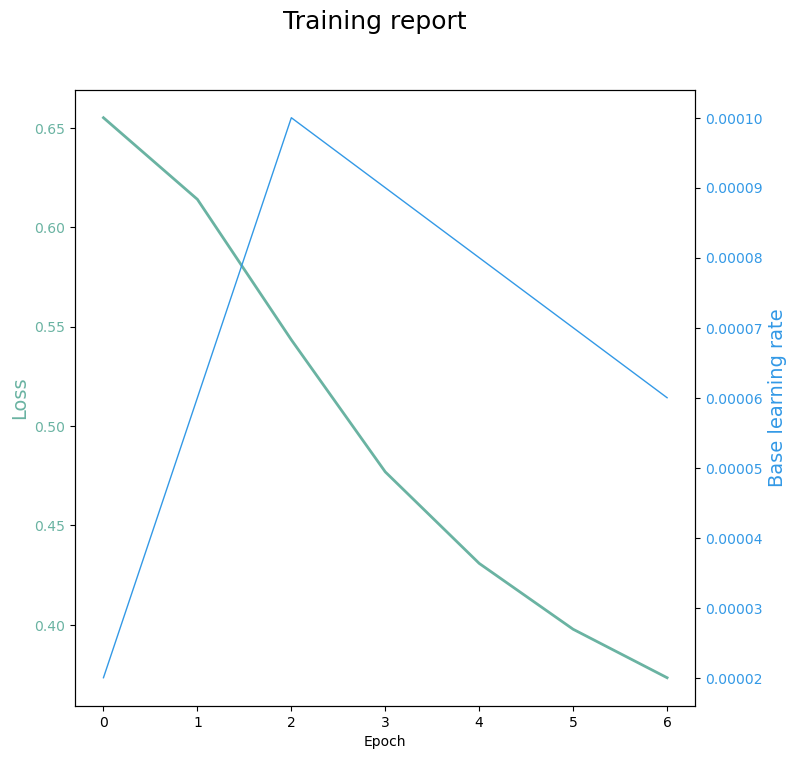

In [4]:
plot_report(history, x_locator_tick=2)

#### Step 2 - Segmentation Fine-tuning

Once you have optimized the parameters and pre-trained a backbone the you believe is sufficient, it's time to finetune a model to a specific task. For this challenge we want to segment kerogen macerals on plain light polished section images. The Onward team has been experimenting with Vision Transformers this year and we've created a finetuning module for you to create a model for this very task. This model is a combination of several repos and is intended to act as a starting point for your thinking, not the final answer. You are free to not only adjust the training parameters, but also the internal architecture of the model. We encourage you to experiement with new methods that produce new and possible better results!

In [ ]:
# Data in your dataset catalog should .jpg images and associated .npy labels. We recommend to start with data from Stranger Sections 2 challange.
dataset = "./data/training_data/"

history = finetune_vit(
    dataset, #this is your dataset catalog
    output="checkpoints/ViT_B_16_stranger_sections2.pth", # your checkpoint will be saved to this location - catalog must exist before training!
    transform_kwargs={
        "min_scale": 0.33, 
        "normalize": False,
    },  # this will be passed to lightly.transforms.mae_transform.MAETransform
    vit_model="ViT_B_16", # this is the base modwl we will use, same one you used for pretraining
    starting_weights="ViT_B_16_Weights.DEFAULT", # this can be either path to checkpoint or one of the default weights
    batch_size=16,
    n_workers=4,  # to achieve best performance we recommend setting this value to match number of physical cores of your CPU
    optimizer="SGD",  # AdamW and SGD are supported out of the box
    optimizer_kwargs={
        "lr": 1e-4,
        "momentum": 0.0,
    },  # this will be passed to optimizer constructor
    warmup_epochs=2,  # tune Learning Rate schedules to match your needs
    start_factor=0.2,  # starting decrease factor for warmup
    linear_schedule=True,
    end_factor=0.5,  # final decrease factor for LR schedule
    n_epochs=5,  # number of non-warmup training epochs
    decoder_dim=256,  # we will use smaller decoder as we're training the smallest model of ViT family
    freeze_projection=True, # we want to freeze the projection head and embeddings when finetuning
    freeze_embeddings=True)

Plot the loss history below

In [ ]:
plot_report(history, x_locator_tick=2)